Risk Models Using Tree-based Models




In this project, tree based models by predicting the 10-year risk of death of individuals from the NHANES I epidemiology dataset (for a detailed description of this dataset in CDC Website).

We will look on:

1.Dealing with Missing Data(Complete Case Analysis,Imputation)

2.Decision Trees(Evaluation ,Regularization)


3.Random Forests (Hyperparameter Tuning)


Dataset description:Visit the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx).


#**1. Import Packages**

In this section, we load all the essential Python libraries required:

**shap** – used to interpret and explain predictions generated by machine learning models.

**sklearn** – a widely used library that provides tools for building, training, and evaluating machine learning models.

**itertools** – offers utilities for handling and combining iterables such as lists or sequences.

**pydotplus** – used together with IPython.display.Image to visualize structures like decision trees.

**numpy** – a foundational library for scientific computing and numerical operations.

**pandas** – the primary library for handling, manipulating, and exploring datasets.

**seaborn** – a visualization library that provides convenient tools, including functions to help inspect missing data.

**matplotlib** – a core plotting library for generating a wide range of static visualizations.

In [ ]:
import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

from sklearn.tree import export_graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
import os


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# We'll also import some helper functions that will be useful later on.



In [ ]:
!pip install lifelines


In [ ]:
import lifelines


#**2. The Dataset**


Run the next cell to load in the NHANES I epidemiology dataset. This dataset contains various features of hospital patients as well as their outcomes, i.e. whether or not they died within 10 years.

#**def nhanesi()**

The **nhanesi()** function simply loads your NHANES I dataset from two CSV files—one containing the features (X) and the other containing the labels (y). It returns these in the correct format so the rest of your machine-learning code can use them. If you turn on display=True, the function also makes the data easier to read by changing the numeric values of the “Sex” column (1/0) into the words “Male” and “Female.” In short, this function is just a convenient loader that reads the data, formats it properly, and optionally makes it more human-friendly for viewing.

In [ ]:
def nhanesi(data_x, data_y, display=False):
    """Same as shap, but we use local data."""
    X = pd.read_csv(data_x)
    y = pd.read_csv(data_y)["y"]
    if display:
        X_display = X.copy()
        X_display["Sex"] = ["Male" if v == 1 else "Female" for v in X["Sex"]]
        return X_display, np.array(y)
    return X, np.array(y)


#**def load_data()**

The **load_data()** function prepares the NHANES dataset for a survival-style prediction task. It first loads the data using nhanesi() and cleans it by removing the first column, attaching the outcome (time until death) and a death indicator. Negative times mean the person survived beyond the study period, so death is set to 0 and the time is made positive. It removes any rows with missing values and keeps only people who either died or lived longer than a chosen threshold. Then it separates the features (X) and the target label (whether the person dies before the threshold). After splitting the data into development and test sets, it artificially creates missing values in the "Systolic BP" column for some rows—based on age-dependent dropping probability—to simulate real-world missing data patterns. Finally, it returns the processed training (X_dev, y_dev) and testing (X_test, y_test) datasets.

In [ ]:
def load_data(threshold, data_x, data_y):
    X, y = nhanesi(data_x, data_y)
    df = X.drop([X.columns[0]], axis=1)
    df.loc[:, 'time'] = y
    df.loc[:, 'death'] = np.ones(len(X))
    df.loc[df.time < 0, 'death'] = 0
    df.loc[:, 'time'] = np.abs(df.time)
    df = df.dropna(axis='rows')
    mask = (df.time > threshold) | (df.death == 1)
    df = df[mask]
    X = df.drop(['time', 'death'], axis='columns')
    y = df.time < threshold

    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    feature_y = 'Systolic BP'
    frac = 0.7

    drop_rows = X_dev.sample(frac=frac, replace=False,
                             weights=[prob_drop(X_dev.loc[i, 'Age']) for i in
                                      X_dev.index], random_state=10)
    drop_rows.loc[:, feature_y] = None
    drop_y = y_dev[drop_rows.index]
    X_dev.loc[drop_rows.index, feature_y] = None

    return X_dev, X_test, y_dev, y_test


#**prob_drop()**
The **prob_drop()** function takes a person’s age and calculates the probability that their data (specifically “Systolic BP”) will be intentionally dropped to simulate missing values. It uses a logistic function, which increases with age, meaning older people have a higher chance of having missing blood pressure data—just like in real medical datasets where older patients often have more incomplete records. The function returns a value between 0 and 1 representing this probability, where younger individuals have a low chance of missing data and older individuals have a much higher chance.

In [ ]:
def prob_drop(age):
    return 1 - (np.exp(0.25 * age - 5) / (1 + np.exp(0.25 * age - 5)))

This line calls the load_data() function with a threshold of 10 years and two CSV files containing the NHANES features and labels. The function processes and cleans the dataset, creates the target variable (whether someone died before 10 years), splits the data into a development set (X_dev, y_dev) and a test set (X_test, y_test), and also artificially introduces missing values in the “Systolic BP” column to mimic real-world data. After running this line, you end up with four prepared datasets ready for model training (X_dev, y_dev) and final evaluation (X_test, y_test).

In [ ]:
X_dev, X_test, y_dev, y_test = load_data(10, '/NHANESI_subset_X.csv', '/NHANESI_subset_y.csv')

/tmp/ipython-input-3147914818.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  drop_rows.loc[:, feature_y] = None


X_dev, y_dev, X_test, and y_test are the four datasets created after loading and preparing the NHANES data. The X_dev and y_dev pairs form the development (training) set, which you use to train and tune your models. The X_test and y_test pairs form the test set, which is kept separate and used only at the end to evaluate how well the trained model performs on completely unseen data. In simple terms, the development set is for learning, and the test set is for checking how good that learning actually was.

In [ ]:
X_dev, X_test, y_dev, y_test

(       Age  Diastolic BP  Poverty index  Race  Red blood cells  \
 6807  69.0          74.0          372.0   1.0             46.1   
 1053  68.0         110.0          999.0   2.0             50.5   
 5782  37.0          80.0          491.0   1.0             43.2   
 5173  57.0          70.0          584.0   1.0             45.5   
 6118  29.0          60.0          308.0   1.0             48.1   
 ...    ...           ...            ...   ...              ...   
 6090  63.0          80.0          120.0   1.0             77.7   
 8626  71.0          90.0          117.0   2.0             46.8   
 1511  53.0          90.0          157.0   1.0             42.5   
 8628  73.0          70.0           71.0   2.0             40.1   
 1443  68.0          86.0          176.0   1.0             48.5   
 
       Sedimentation rate  Serum Albumin  Serum Cholesterol  Serum Iron  \
 6807                25.0            3.9              193.0        99.0   
 1053                18.0            4.1    

This below line splits the development set (X_dev, y_dev) into training and validation subsets. X_train and y_train are used to fit the model, while X_val and y_val are used to tune hyperparameters and check performance during training without touching the final test set. Here, 25% of the development data is set aside for validation, and the random_state=10 ensures that the split is reproducible, giving the same subsets every time you run it.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

#**Explore the Dataset**
The first step is to familiarize yourself with the data. Run the next cell to get the size of your training set and look at a small sample.

In [ ]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


In [ ]:
y_train.head(20)

,time
1599,False
2794,True
1182,False
6915,False
500,False
1188,True
9739,False
3266,False
6681,False
8822,False


Use the next cell to examine individual cases and familiarize yourself with the features

In [ ]:
i = 10
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    67.000000
Diastolic BP           94.000000
Poverty index         114.000000
Race                    1.000000
Red blood cells        43.800000
Sedimentation rate     12.000000
Serum Albumin           3.700000
Serum Cholesterol     178.000000
Serum Iron             73.000000
Serum Magnesium         1.850000
Serum Protein           7.000000
Sex                     1.000000
Systolic BP           140.000000
TIBC                  311.000000
TS                     23.500000
White blood cells       4.300000
BMI                    17.481227
Pulse pressure         46.000000
Name: 5856, dtype: float64

Died within 10 years? True


#**Dealing with Missing Data**


Looking at our data in X_train, we see that some of the data is missing: some values in the output of the previous cell are marked as NaN ("not a number").

Missing data is a common occurrence in data analysis, that can be due to a variety of reasons, such as measuring instrument malfunction, respondents not willing or not able to supply information, and errors in the data collection process.

Let's examine the missing data pattern. seaborn is an alternative to matplotlib that has some convenient plotting functions for data analysis. We can use its heatmap function to easily visualize the missing data pattern.

Run the cell below to plot the missing data:

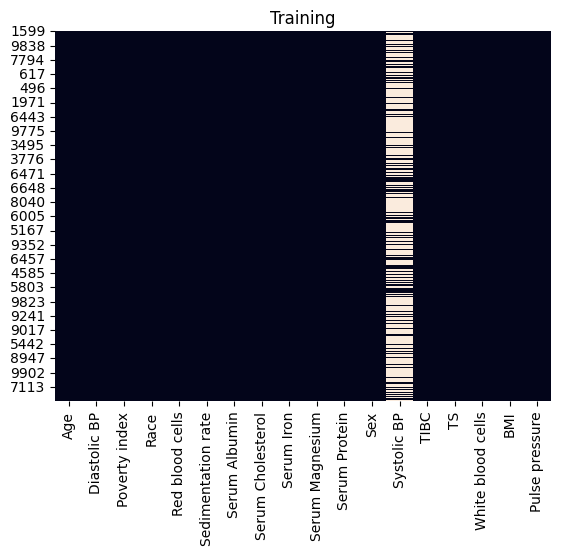

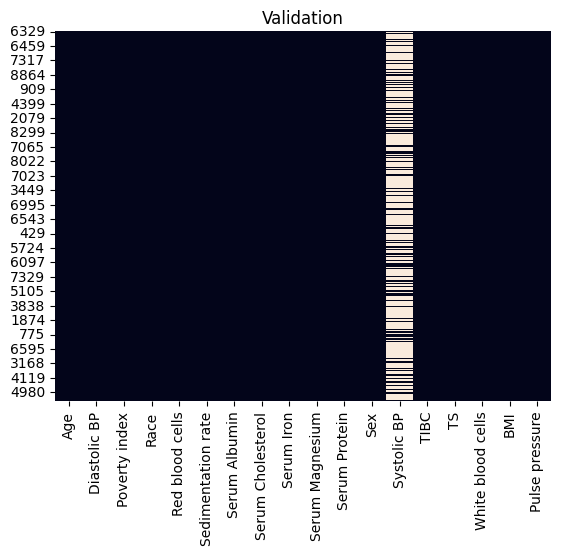

In [ ]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

#**fraction_rows_missing**


In the cell below,  a function to compute the fraction of cases with missing data. This will help us decide how we handle this missing data in the future.

#**fraction_rows_missing()**
The **fraction_rows_missing()** function calculates how many rows in a dataframe have at least one missing value. It first checks each row to see if any column is missing (isnull().any(axis=1)), counts how many such rows exist, and then divides by the total number of rows to get a fraction between 0 and 1. The result tells you what portion of the dataset contains incomplete data, which is useful for understanding how much cleaning or imputation is needed.

In [ ]:

def fraction_rows_missing(df):
    '''
    Return percent of rows with any missing
    data in the dataframe.

    Input:
        df (dataframe): a pandas dataframe with potentially missing data
    Output:
        frac_missing (float): fraction of rows with missing data
    '''

    missing_rows = df.isnull().any(axis=1)

    # fraction calculation
    frac_missing = missing_rows.sum() / len(df)

    return float(frac_missing)


#**fraction_rows_missing_test()**
This function is designed to test and verify the **fraction_rows_missing()** function (or any similar target function) to make sure it correctly calculates the fraction of rows with missing data. It first creates an example dataframe (df_test) with some missing values and prints it along with the fraction of missing rows as computed by the target function. Then it applies the same function to your training, validation, and test sets (X_train, X_val, X_test) to see what fraction of rows have missing data in each. Finally, it defines a set of unit tests to automatically check that the target function returns the expected value, has the correct data type, and produces the right output, using the helper multiple_test() function. This ensures your missing-data calculation works correctly before moving on to imputation or modeling.

In [ ]:
def fraction_rows_missing_test(target, X_train, X_val, X_test):
    df_test = fraction_rows_missing_test_case()

    print("Example dataframe:\n\n", df_test, "\n")
    print("Computed fraction missing: ", target(df_test))
    print("Fraction of rows missing from X_train: ", target(X_train))
    print("Fraction of rows missing from X_val: ", target(X_val))
    print("Fraction of rows missing from X_test: ", target(X_test))

    expected_output = 0.75

    test_cases = [
        {
            "name":"datatype_check",
            "input": [df_test],
            "expected": expected_output,
            "error": "Data-type mismatch."
        },
        {
            "name": "shape_check",
            "input": [df_test],
            "expected": expected_output,
            "error": "Wrong shape."
        },
        {
            "name": "equation_output_check",
            "input": [df_test],
            "expected": expected_output,
            "error": "Wrong output."
        }
    ]

    multiple_test(test_cases, target)

#**fraction_rows_missing_test_case**

This function creates a small example dataframe (df_test) specifically to test missing-data functions. The dataframe has two columns (a and b) with some entries set to None (missing). It then returns this dataframe so it can be used by functions like fraction_rows_missing_test() to check whether your missing-data calculation is working correctly. In this example, 3 out of 4 rows contain at least one missing value, which makes it a good test case.

In [ ]:
def fraction_rows_missing_test_case():
    df_test = pd.DataFrame({'a':[None, 1, 1, None], 'b':[1, None, 0, 1]})

    return df_test


This code defines a unit testing framework to automatically check the correctness of functions. It includes three types of checks: datatype_check ensures the output has the correct Python type, equation_output_check ensures the output value is correct, and shape_check ensures arrays or dataframes have the expected shape. The functions handle single values, lists/tuples, and dictionaries recursively. The multiple_test function runs a series of test cases, each with an expected output, input, and error message, and reports which tests pass or fail. If any test fails, it raises an AssertionError with details, helping you catch mistakes in your code without manually inspecting results. Essentially, it automates verification of your functions for correctness, type, and shape.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys

np.random.seed(3)

def datatype_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += datatype_check(expected_output[key],
                                         target_output[key], error)
            except:
                print("Error: {} in variable {}. Got {} but expected type {}".format(error,
                                                                          key, type(target_output[key]), type(expected_output[key])))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try:
                success += datatype_check(expected_output[i],
                                         target_output[i], error)
            except:
                print("Error: {} in variable {}, Got {}  but expected type {}".format(error,
                                                                          i, type(target_output[i]), type(expected_output[i])))
        if success == len(target_output):
            return 1
        else:
            return 0

    else:
        assert isinstance(target_output, type(expected_output))
        return 1

def equation_output_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += equation_output_check(expected_output[key],
                                         target_output[key], error)
            except:
                print(expected_output[key],
                                         target_output[key])
                print("Error: {} for variable {}.".format(error,
                                                                          key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try:
                success += equation_output_check(expected_output[i],
                                         target_output[i], error)
            except:
                print("Error: {} for variable in position {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0

    else:
        if hasattr(target_output, 'shape'):
            np.testing.assert_array_almost_equal(target_output, expected_output)
        else:
            assert target_output == expected_output
        return 1

def shape_check(expected_output, target_output, error):
    success = 0
    if isinstance(target_output, dict):
        for key in target_output.keys():
            try:
                success += shape_check(expected_output[key],
                                         target_output[key], error)
            except:
                print("Error: {} for variable {}.".format(error, key))
        if success == len(target_output.keys()):
            return 1
        else:
            return 0
    elif isinstance(target_output, tuple) or isinstance(target_output, list):
        for i in range(len(target_output)):
            try:
                success += shape_check(expected_output[i],
                                         target_output[i], error)
            except:
                print("Error: {} for variable {}.".format(error, i))
        if success == len(target_output):
            return 1
        else:
            return 0

    else:
        if hasattr(target_output, 'shape'):
            assert target_output.shape == expected_output.shape
        return 1

def multiple_test(test_cases, target):
    success = 0
    for test_case in test_cases:
        try:
            target_answer = target(*test_case['input'])
            if test_case['name'] == "datatype_check":
                success += datatype_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "equation_output_check":
                success += equation_output_check(test_case['expected'], target_answer, test_case['error'])
            if test_case['name'] == "shape_check":
                success += shape_check(test_case['expected'], target_answer, test_case['error'])
        except:
            print("Error: " + test_case['error'])

    if success == len(test_cases):
        print("\033[92m All tests passed.")
    else:
        print('\033[92m', success," Tests passed")
        print('\033[91m', len(test_cases) - success, " Tests failed")
        raise AssertionError("Not all tests were passed for {}. Check your equations and avoid using global variables inside the function.".format(target.__name__))

This line runs a test to check whether your fraction_rows_missing() function is working correctly. It uses the fraction_rows_missing_test() helper function, passing in your function along with the training, validation, and test datasets (X_train, X_val, X_test). The test will print example outputs, compute the fraction of rows with missing values for each dataset, and automatically verify that your function returns the correct type, value, and shape. If everything is correct, it will confirm that all tests passed; otherwise, it will show which checks failed so you can fix your function.

In [ ]:
### test cell
fraction_rows_missing_test(fraction_rows_missing, X_train, X_val, X_test)

Example dataframe:

      a    b
0  NaN  1.0
1  1.0  NaN
2  1.0  0.0
3  NaN  1.0 

Computed fraction missing:  0.75
Fraction of rows missing from X_train:  0.6986594132504371
Fraction of rows missing from X_val:  0.703962703962704
Fraction of rows missing from X_test:  0.0
 All tests passed.


We see that our train and validation sets have missing values, but luckily our test set has complete cases.

As a first pass, we will begin with a complete case analysis, dropping all of the rows with any missing data. Run the following cell to drop these rows from our train and validation sets.

These lines create a complete-case version of your training and validation data by removing any rows that contain missing values. X_train_dropped and X_val_dropped are the feature sets with all missing-data rows removed, and y_train_dropped and y_val_dropped are the corresponding labels, aligned with the remaining rows. Finally, the code prints the shape of the cleaned training data and shows the first few rows, so you can see how many rows were dropped and what the resulting dataset looks like. This approach is called complete-case analysis, where only fully observed data is used for model training.

In [ ]:
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

### Notice the new shape of X
print("X_train_dropped shape: {}".format(X_train_dropped.shape))
X_train_dropped.head()

X_train_dropped shape: (1551, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
5856,67.0,94.0,114.0,1.0,43.8,12.0,3.7,178.0,73.0,1.85,7.0,1.0,140.0,311.0,23.5,4.3,17.481227,46.0
9374,68.0,80.0,201.0,1.0,46.2,20.0,4.1,223.0,204.0,1.54,7.2,1.0,140.0,275.0,74.2,17.2,20.690581,60.0
8819,68.0,80.0,651.0,1.0,47.7,16.0,4.3,178.0,168.0,1.97,7.3,1.0,102.0,339.0,49.6,10.2,27.719091,22.0
7331,73.0,88.0,68.0,2.0,42.1,19.0,3.6,215.0,64.0,1.59,5.7,2.0,190.0,334.0,19.2,6.6,31.880432,102.0


#**Decision Trees**
Having just learned about decision trees, you choose to use a decision tree classifier. Use scikit-learn to build a decision tree for the hospital dataset using the train set.

These lines create and train a decision tree classifier. DecisionTreeClassifier(max_depth=None, random_state=10) initializes the model with no limit on the depth of the tree, meaning it can grow until all leaves are pure or contain very few samples. The random_state=10 ensures the results are reproducible. Then, dt.fit(X_train_dropped, y_train_dropped) trains the decision tree on the complete-case training data, learning patterns that predict whether a patient dies before the 10-year threshold. After this, the model is ready to make predictions on validation or test data.

In [ ]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(random_state=10)

Next we will evaluate our model. We'll use C-Index for evaluation.

Remember from lesson 4 of week 1 that the C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).

More formally, defining permissible pairs of patients as pairs where the outcomes are different, concordant pairs as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and ties as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:

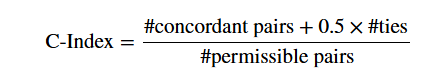

Run the next cell to compute the C-Index on the train and validation set (we've given you an implementation this time).

The cindex() function computes the concordance index (C-index), which is a metric commonly used in survival analysis to measure how well a model’s predicted scores match the actual outcomes. It takes the true outcomes y_true (e.g., time until death or event) and the model’s predicted risk scores, and returns a value between 0 and 1. A C-index of 1 means perfect prediction, 0.5 means random guessing, and values below 0.5 indicate worse-than-random predictions. This function uses lifelines.utils.concordance_index() to calculate the score, providing a standardized way to evaluate model performance in predicting time-to-event data.

In [ ]:
def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)


These lines evaluate how well the trained decision tree predicts the risk of death. dt.predict_proba(X_train_dropped)[:, 1] gives the predicted probability of the positive class (death before 10 years) for each sample in the training set, and cindex(y_train_dropped.values, y_train_preds) calculates the C-index to see how well the predicted probabilities match the actual outcomes. The same process is repeated on the validation set (X_val_dropped) to check how well the model generalizes to unseen data. Printing both C-index values lets you compare training performance versus validation performance and check for overfitting.

In [ ]:
y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")


y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")



Train C-Index: 1.0
Val C-Index: 0.5629321808510638


Unfortunately our tree seems to be overfitting: it fits the training data so closely that it doesn't generalize well to other samples such as those from the validation set.

The training C-index comes out to 1.0 because, when initializing DecisionTreeClasifier, we have left max_depth and min_samples_split unspecified. The resulting decision tree will therefore keep splitting as far as it can, which pretty much guarantees a pure fit to the training data.

To handle this, you can change some of the hyperparameters of our tree

#**dt_hyperparams**
Try and find a set of hyperparameters that improves the generalization to the validation set and recompute the C-index. If you do it right, you should get C-index above 0.6 for the validation set.

You can refer to the documentation for the sklearn DecisionTreeClassifier.

This code defines a set of hyperparameters for the decision tree that you can experiment with to improve model performance. The dt_hyperparams dictionary specifies options like max_depth (limits how deep the tree can grow), min_samples_split (minimum number of samples required to split a node), min_samples_leaf (minimum samples in a leaf), and criterion (how the tree decides the best split, e.g., “gini” or “entropy”). By adjusting these hyperparameters, you can control the complexity of the tree, reduce overfitting, and aim to achieve a C-index above 0.6 on the validation set. This is the start of hyperparameter tuning.

In [ ]:
# Experiment with different hyperparameters for the DecisionTreeClassifier
# until get a c-index above 0.6 for the validation set
dt_hyperparams = {
    # set your own hyperparameters below, such as 'min_samples_split': 1

    ### START CODE HERE ###

    'max_depth': 3,                # limit tree depth
    'min_samples_split': 7,       # minimum samples to split a node
    'min_samples_leaf': 8,         # minimum samples per leaf
    'criterion': 'gini',        # split criterion: "gini" (default) or "entropy"


    ### END CODE HERE ###
}

Run the next cell to fit and evaluate the regularized tree.

These lines create a decision tree classifier using the hyperparameters defined in dt_hyperparams and train it on the complete-case training data. The model then predicts the probability of death for both the training and validation sets. The C-index is computed for each set to evaluate how well the tree’s predictions match the actual outcomes. Printing these values allows you to check both training performance and generalization to the validation data, with the goal of achieving a validation C-index above 0.6. This is a practical example of hyperparameter tuning to improve model performance while avoiding overfitting.

In [ ]:

dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 0.688738755448391
Val C-Index (expected > 0.6): 0.6302692819148936


Expected Output:
Train C-Index > 0.6
Val C-Index > 0.6
If your output is not greater than 0.6, try changing and tweaking your hyperparameters in Ex 2.

If you used a low max_depth you can print the entire tree. This allows for easy interpretability. Run the next cell to print the tree splits.

In [ ]:
from io import StringIO


These lines visualize your trained decision tree. export_graphviz converts the tree structure into the DOT format, including options to fill nodes with colors (filled=True), round the corners (rounded=True), show proportions of samples in each node (proportion=True), display feature names, and use class names ['neg', 'pos']. dot_data.getvalue() retrieves this DOT representation, which is then converted to a graph image using pydotplus.graph_from_dot_data(). Finally, Image(graph.create_png()) displays the tree as a PNG image directly in your notebook, so you can see how the tree splits features to make predictions.

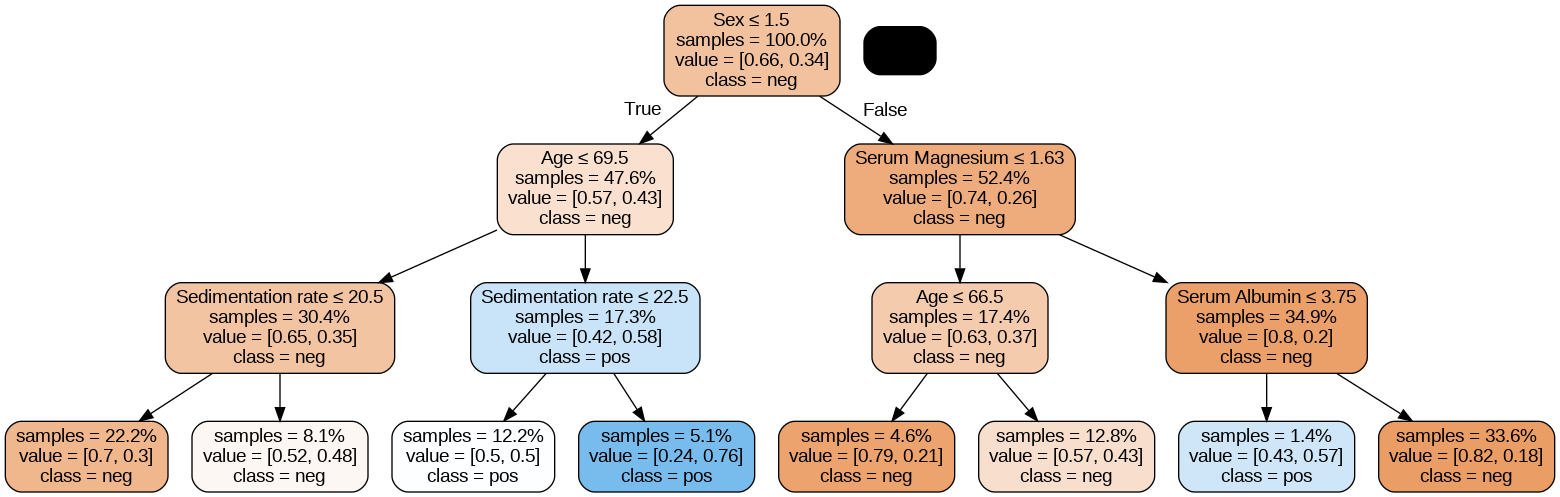

In [ ]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train_dropped.columns, out_file=dot_data,
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

**Overfitting, underfitting, and the bias-variance tradeoff**

If you tested several values of max_depth, you may have seen that a value of 3 gives training and validation C-Indices of about 0.689 and 0.630, and that a max_depth of 2 gives better agreement with values of about 0.653 and 0.607. In the latter case, we have further reduced overfitting, at the cost of a minor loss in predictive performance.

Contrast this with a max_depth value of 1, which results in C-Indices of about 0.597 for the training set and 0.598 for the validation set: we have eliminated overfitting but with a much stronger degradation of predictive performance.

Lower predictive performance on the training and validation sets is indicative of the model underfitting the data: it neither learns enough from the training data nor is able to generalize to unseen data (the validation data in our case).

Finding a model that minimizes and acceptably balances underfitting and overfitting (e.g. selecting the model with a max_depth of 2 over the other values) is a common problem in machine learning that is known as the bias-variance tradeoff.

#**Random Forests**
No matter how you choose hyperparameters, a single decision tree is prone to overfitting. To solve this problem, you can try random forests, which combine predictions from many different trees to create a robust classifier.

As before, we will use scikit-learn to build a random forest for the data. We will use the default hyperparameters.

These lines create and train a random forest classifier, which is an ensemble of many decision trees. RandomForestClassifier(n_estimators=100, random_state=10) initializes a forest with 100 trees, where each tree is trained on a random subset of the data and features. The random_state=10 ensures reproducibility. The rf.fit(X_train_dropped, y_train_dropped) line trains all the trees on the complete-case training data, allowing the forest to learn patterns that predict whether a patient dies before the 10-year threshold. Using multiple trees generally improves accuracy and reduces overfitting compared to a single decision tree.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(random_state=10)

These lines evaluate how well the random forest model predicts the risk of death. rf.predict_proba(X_train_dropped)[:, 1] gives the predicted probability of the positive class (death before 10 years) for each sample in the training set, and cindex(y_train_dropped.values, y_train_rf_preds) computes the C-index to measure how well these probabilities match the actual outcomes. The same steps are repeated on the validation set. Printing both C-index values lets you compare training performance versus validation performance, helping you assess how well the random forest generalizes to unseen data.

In [ ]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6660488696808511


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

n_estimators: the number of trees used in the forest.


max_depth: the maximum depth of each tree.


min_samples_leaf: the minimum number (if int) or proportion (if float) of samples in a leaf.


The approach we implement to tune the hyperparameters is known as a grid search:

We define a set of possible values for each of the target hyperparameters.

A model is trained and evaluated for every possible combination of hyperparameters.

The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

#**holdout_grid_search**

this function systematically tests all hyperparameter options, evaluates each one on the validation set, and returns the model and settings that perform the best. It’s called holdout grid search because it uses a fixed validation set (the holdout) rather than cross-validation to pick the best parameters.

In [ ]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                            names to range of values for grid search
        fixed_hyperparams (dict): dictionary of fixed hyperparameters that
                                  are not included in the grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                             validation set
        best_hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                                 names to values in best_estimator
    '''
    best_estimator = None
    best_hyperparams = {}

    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()

    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]

        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)

        # get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)

        # compute cindex for predictions
        estimator_score = cindex(y_val_hp, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # if new high score, update high score, best estimator
        # and best params
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)

    return best_estimator, best_hyperparams

#**random_forest_grid_search**

random_forest_grid_search
In the cell below, define the values you want to run the hyperparameter grid search on, and run the cell to find the best-performing set of hyperparameters.

Your objective is to get a C-Index above 0.6 on both the train and validation set.

#**random_forest_grid_search**

The random_forest_grid_search() function performs a hyperparameter search for a random forest model using a holdout validation set. It first defines ranges of hyperparameters to try—such as the number of trees (n_estimators), the maximum depth of each tree (max_depth), and the minimum number of samples per leaf (min_samples_leaf)—while keeping some parameters fixed (like random_state). It then calls holdout_grid_search() to systematically train random forests for every combination of hyperparameters, evaluate their performance on the validation set using the C-index, and select the combination that performs the best. After finding the best model, it prints the hyperparameters and computes the C-index on both training and validation sets to check performance. Finally, it returns the best-trained random forest model and the hyperparameter settings that gave the highest validation performance.

In [ ]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):

    # Define ranges for the chosen random forest hyperparameters
    hyperparams = {

        ### START CODE HERE (REPLACE array values with your code) ###

        # how many trees should be in the forest (int)
        'n_estimators': [100, 200, 500],

        # the maximum depth of trees in the forest (int)

        'max_depth': [None, 5, 10, 20],

        # the minimum number of samples in a leaf as a fraction
        # of the total number of samples in the training set
        # Can be int (in which case that is the minimum number)
        # or float (in which case the minimum is that fraction of the
        # number of training set samples)
        'min_samples_leaf': [1, 2, 5, 10]

        ### END CODE HERE ###
    }


    fixed_hyperparams = {
        'random_state': 10,
    }

    rf = RandomForestClassifier

    best_rf, best_hyperparams = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                    X_val_dropped, y_val_dropped, hyperparams,
                                                    fixed_hyperparams)

    print(f"Best hyperparameters:\n{best_hyperparams}")


    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {cindex(y_train_dropped, y_train_best)}")

    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Val C-Index: {cindex(y_val_dropped, y_val_best)}")

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)

    return best_rf, best_hyperparams

In [ ]:
best_rf, best_hyperparams = random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped)

[1/48] {'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 1}
Val C-Index: 0.6660488696808511

[2/48] {'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 2}
Val C-Index: 0.6667553191489362

[3/48] {'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 5}
Val C-Index: 0.676595744680851

[4/48] {'n_estimators': 100, 'max_depth': None, 'min_samples_leaf': 10}
Val C-Index: 0.6604720744680851

[5/48] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 1}
Val C-Index: 0.6687666223404255

[6/48] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 2}
Val C-Index: 0.672157579787234

[7/48] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 5}
Val C-Index: 0.6761303191489362

[8/48] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 10}
Val C-Index: 0.6737865691489362

[9/48] {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 1}
Val C-Index: 0.6645113031914893

[10/48] {'n_estimators': 100, 'max_depth': 10, 'min_samples_leaf': 2}
Val C-In

Finally, evaluate the model on the test set. This is a crucial step, as trying out many combinations of hyperparameters and evaluating them on the validation set could result in a model that ends up overfitting the validation set. We therefore need to check if the model performs well on unseen data, which is the role of the test set, which we have held out until now.

In [ ]:

y_test_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test.values, y_test_best)}")

Test C-Index: 0.7081325682460655


Expected Output:
Test C-Index > 0.6
If  output is not greater than 0.6, try changing and tweaking  hyperparameters in Ex 3.

#**Imputation**
We've now built and optimized a random forest model on our data. However, there was still a drop in test C-Index. This might be because you threw away more than half of the data of our data because of missing values for systolic blood pressure. Instead, we can try filling in, or imputing, these values.

First, let's explore to see if our data is missing at random or not. Let's plot histograms of the dropped rows against each of the covariates (aside from systolic blood pressure) to see if there is a trend. Compare these to the histograms of the feature in the entire dataset. Try to see if one of the covariates has a signficantly different distribution in the two subsets.

This code visualizes how the distribution of each feature changes when rows with missing values are removed. First, dropped_rows selects all rows in X_train that have any missing value. Then, for every column except 'Systolic BP', it plots two histograms using Seaborn: one for the full dataset and one for the rows that were dropped. This helps you see if removing missing-data rows introduces bias or changes the data distribution, which is important before deciding how to handle missing values. Each plot shows both distributions for easy comparison.

/tmp/ipython-input-2715936941.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
/tmp/ipython-input-2715936941.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='witho

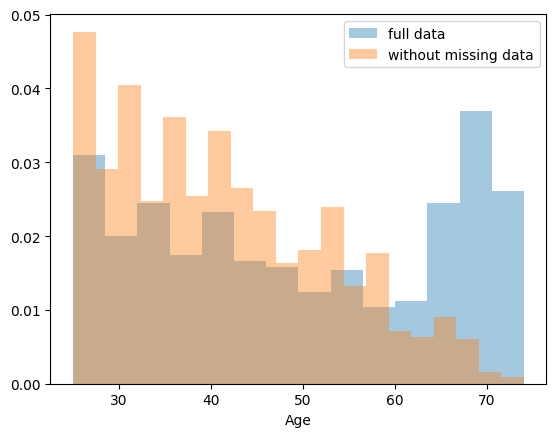

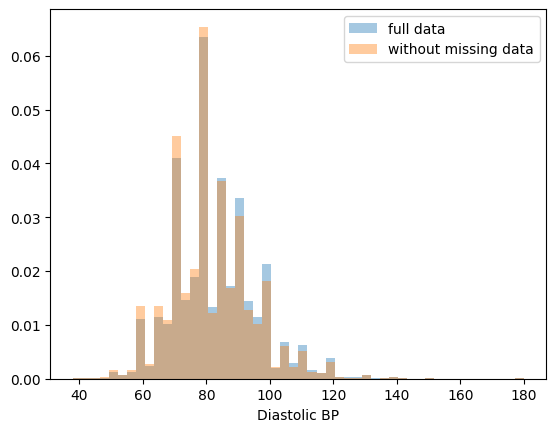

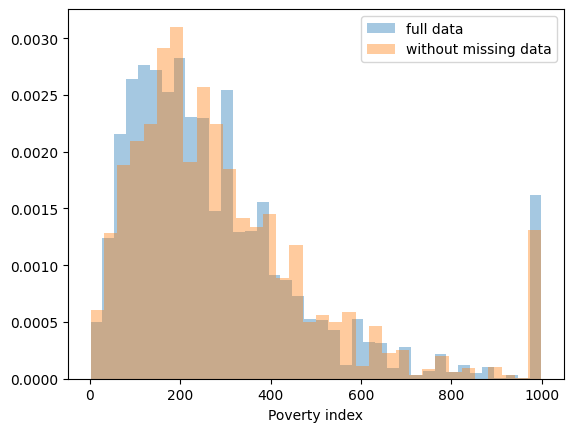

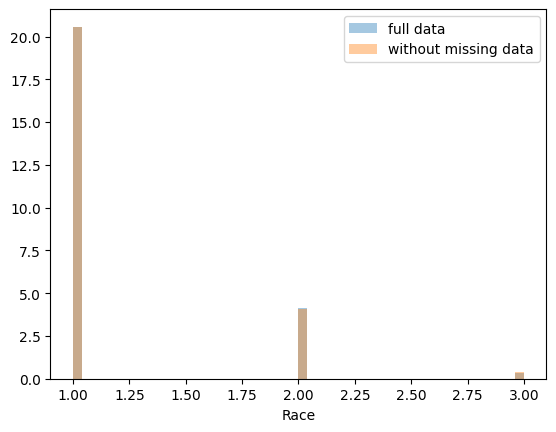

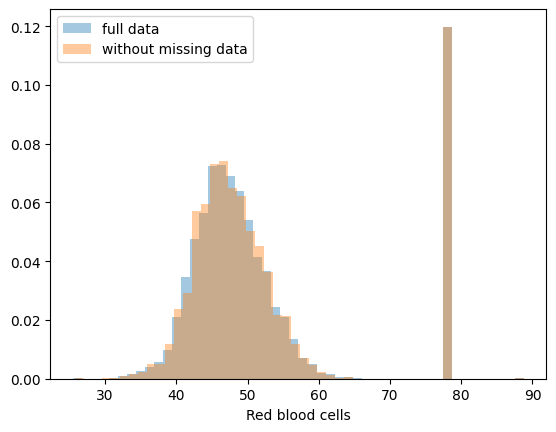

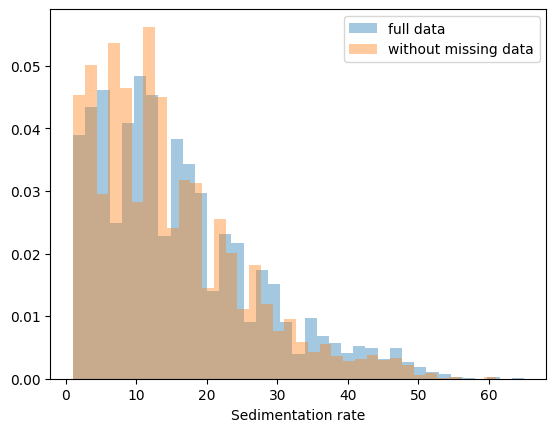

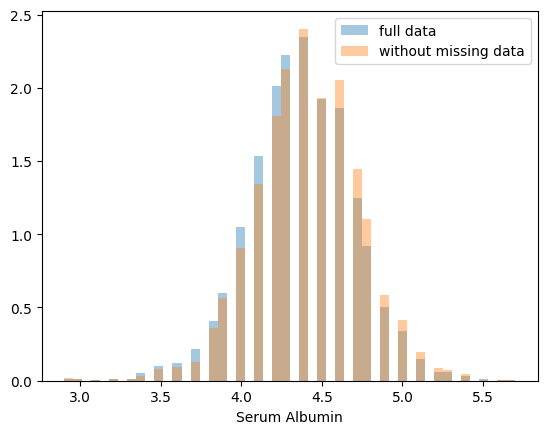

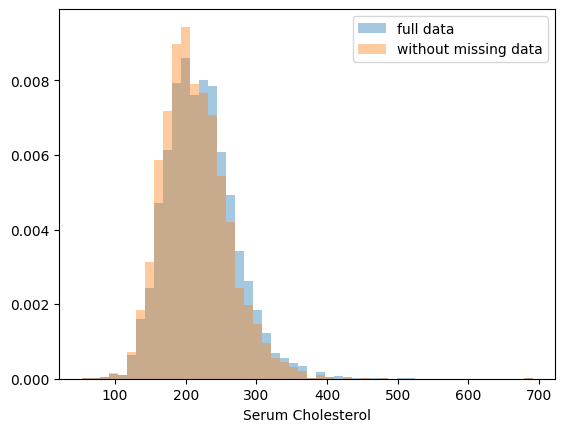

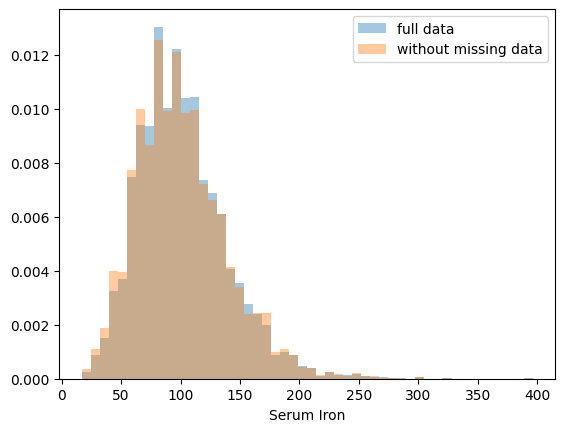

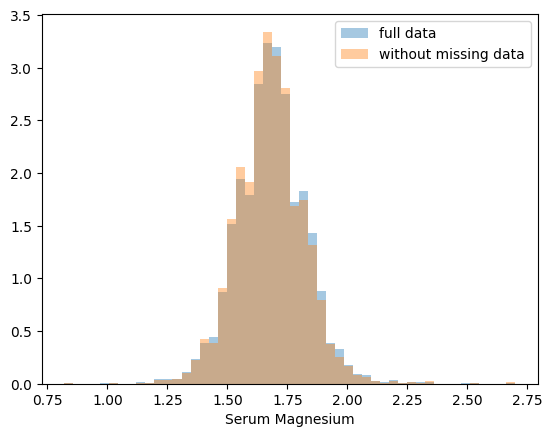

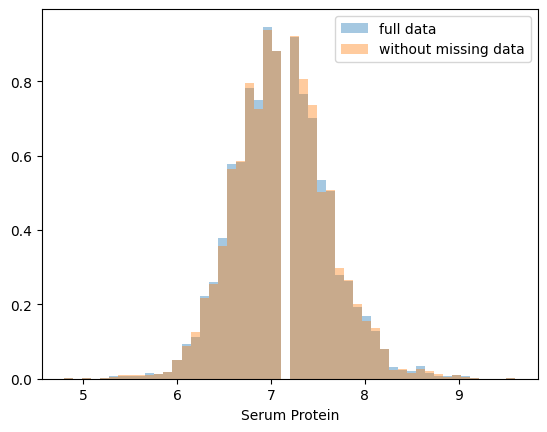

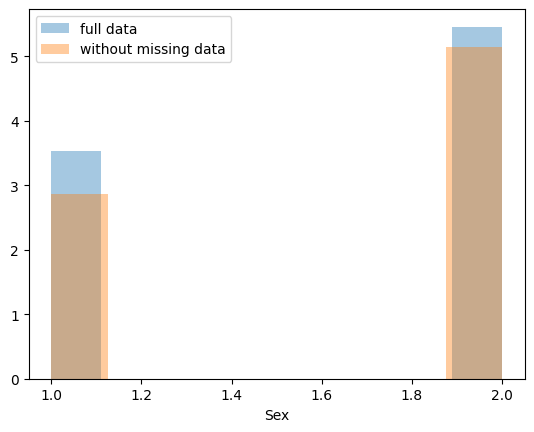

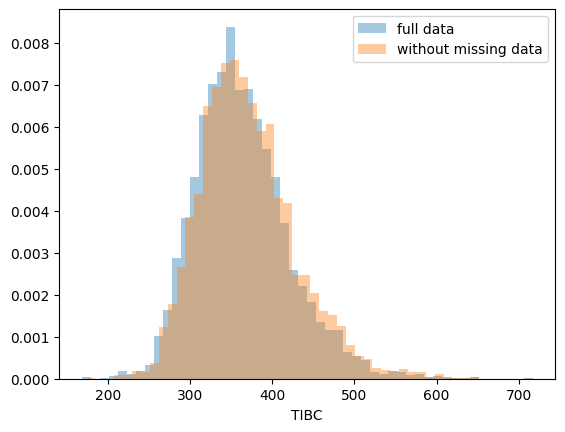

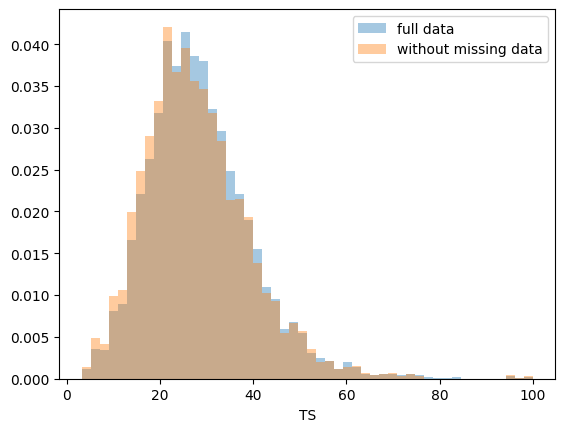

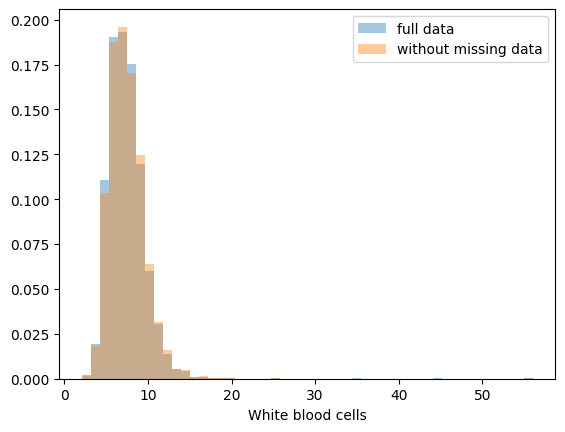

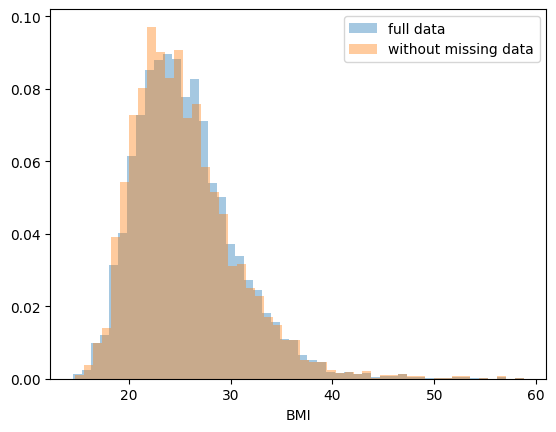

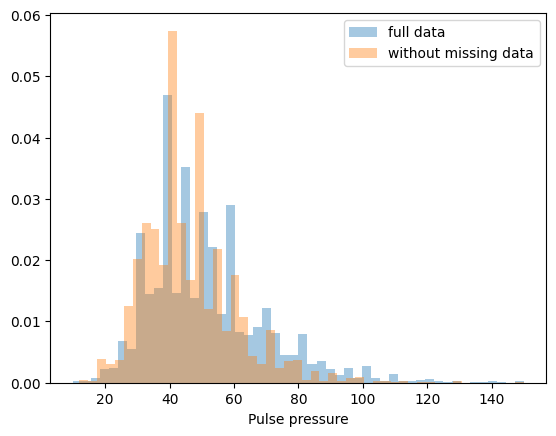

In [ ]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='without missing data')
    plt.legend()

    plt.show()

This code visualizes how the distribution of each feature changes when rows with missing values are removed. First, dropped_rows selects all rows in X_train that have any missing value. Then, for every column except 'Systolic BP', it plots two histograms using Seaborn: one for the full dataset and one for the rows that were dropped. This helps you see if removing missing-data rows introduces bias or changes the data distribution, which is important before deciding how to handle missing values. Each plot shows both distributions for easy comparison.

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def bad_subset(forest, X_test, y_test):
    # define mask to select large subset with poor performance
    # currently mask defines the entire set

    ### START CODE HERE (REPLACE the code after 'mask =' with your code) ###
    mask = X_test["Age"] > 66
    ### END CODE HERE ###

    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)

    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = cindex(y_subgroup.values, y_subgroup_preds)

    return performance, subgroup_size

In [ ]:
#### Test Your Work
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print("Subgroup size should greater than 250, performance should be less than 0.69")
print(f"Your Subgroup size: {subgroup_size}, and your C-Index: {performance}")

Subgroup size should greater than 250, performance should be less than 0.69
Your Subgroup size: 372, and your C-Index: 0.6849039554609846


#**Imputation Approaches**


Seeing that our data is not missing completely at random, we can handle the missing values by replacing them with substituted values based on the other values that we have. This is known as imputation.

The first imputation strategy that we will use is mean substitution: we will replace the missing values for each feature with the mean of the available values. In the next cell, use the SimpleImputer from sklearn to use mean imputation for the missing values.

In [ ]:
# Impute values using the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

#**hyperparams**

Now perform a hyperparameter grid search to find the best-performing random forest model, and report results on the test set.

Define the parameter ranges for the hyperparameter search in the next cell, and run the cell.

In [ ]:
# Define ranges for the random forest hyperparameter search
hyperparams = {
    ### START CODE HERE (REPLACE array values with your code) ###

    # how many trees should be in the forest (int)
    'n_estimators': [200,300,400],

    # the maximum depth of trees in the forest (int)
    'max_depth': [10,13,15],

    # the minimum number of samples in a leaf as a fraction
    # of the total number of samples in the training set
    # Can be int (in which case that is the minimum number)
    # or float (in which case the minimum is that fraction of the
    # number of training set samples)
    'min_samples_leaf': [2,5,10],

    ### END CODE HERE ###
}

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
rf = RandomForestClassifier

rf_mean_imputed, best_hyperparams_mean_imputed = holdout_grid_search(rf, X_train_mean_imputed, y_train,
                                                                     X_val_mean_imputed, y_val,
                                                                     hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/27] {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 2}
Val C-Index: 0.7507941781260653

[2/27] {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 5}
Val C-Index: 0.7528026942343645

[3/27] {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 10}
Val C-Index: 0.7564831642922749

[4/27] {'n_estimators': 200, 'max_depth': 13, 'min_samples_leaf': 2}
Val C-Index: 0.7536278143653414

[5/27] {'n_estimators': 200, 'max_depth': 13, 'min_samples_leaf': 5}
Val C-Index: 0.7559077515693567

[6/27] {'n_estimators': 200, 'max_depth': 13, 'min_samples_leaf': 10}
Val C-Index: 0.7590801213360866

[7/27] {'n_estimators': 200, 'max_depth': 15, 'min_samples_leaf': 2}
Val C-Index: 0.7534410766514889

[8/27] {'n_estimators': 200, 'max_depth': 15, 'min_samples_leaf': 5}
Val C-Index: 0.7518907193527584

[9/27] {'n_estimators': 200, 'max_depth': 15, 'min_samples_leaf': 10}
Val C-Index: 0.7570064641648155

[10/27] {'n_estimators': 300, 'max_depth': 10, 'min_samples_leaf': 2}
Val C-Ind

Expected output
Note, your actual C-Index values will vary depending on the hyperparameters that you choose.

C-Index >= 0.74
Try to get a good C-Index, similar these numbers below:
Performance for best hyperparameters:
- Train C-Index: 0.8109
- Val C-Index: 0.7495
- Test C-Index: 0.7805

Next, we will apply another imputation strategy, known as multivariate feature imputation, using scikit-learn's IterativeImputer class (see the documentation).

With this strategy, for each feature that is missing values, a regression model is trained to predict observed values based on all of the other features, and the missing values are inferred using this model. As a single iteration across all features may not be enough to impute all missing values, several iterations may be performed, hence the name of the class IterativeImputer.

In the next cell, use IterativeImputer to perform multivariate feature imputation.

Note that the first time the cell is run, imputer.fit(X_train) may fail with the message LinAlgError: SVD did not converge: simply re-run the cell.

In [ ]:
# Impute using regression on other covariates
imputer = IterativeImputer(random_state=0, sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


#**hyperparams**
Perform a hyperparameter grid search to find the best-performing random forest model, and report results on the test set. Define the parameter ranges for the hyperparameter search in the next cell, and run the cell.

Target performance
Try to get a text c-index of at least 0.74 or higher.

In [ ]:
# Define ranges for the random forest hyperparameter search
hyperparams = {
    ### START CODE HERE (REPLACE array values with your code) ###

    # how many trees should be in the forest (int)
    'n_estimators': [200,300,500],

    # the maximum depth of trees in the forest (int)
    'max_depth': [8,10,13],

    # the minimum number of samples in a leaf as a fraction
    # of the total number of samples in the training set
    # Can be int (in which case that is the minimum number)
    # or float (in which case the minimum is that fraction of the
    # number of training set samples)
    'min_samples_leaf': [1,3,6],

    ### END CODE HERE ###
}

In [ ]:

rf = RandomForestClassifier

rf_imputed, best_hyperparams_imputed = holdout_grid_search(rf, X_train_imputed, y_train,
                                                           X_val_imputed, y_val,
                                                           hyperparams, {'random_state': 10})

print("Performance for best hyperparameters:")

y_train_best = rf_imputed.predict_proba(X_train_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_imputed.predict_proba(X_val_imputed)[:, 1]
print(f"- Val C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_imputed.predict_proba(X_test)[:, 1]
print(f"- Test C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/27] {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 1}
Val C-Index: 0.7492416494585692

[2/27] {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 3}
Val C-Index: 0.7498822032444592

[3/27] {'n_estimators': 200, 'max_depth': 8, 'min_samples_leaf': 6}
Val C-Index: 0.7515085584499901

[4/27] {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 1}
Val C-Index: 0.7466294928333974

[5/27] {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 3}
Val C-Index: 0.751806035970895

[6/27] {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 6}
Val C-Index: 0.754031688955767

[7/27] {'n_estimators': 200, 'max_depth': 13, 'min_samples_leaf': 1}
Val C-Index: 0.747906257667646

[8/27] {'n_estimators': 200, 'max_depth': 13, 'min_samples_leaf': 3}
Val C-Index: 0.7494653004414392

[9/27] {'n_estimators': 200, 'max_depth': 13, 'min_samples_leaf': 6}
Val C-Index: 0.751630155100871

[10/27] {'n_estimators': 300, 'max_depth': 8, 'min_samples_leaf': 1}
Val C-Index: 0.75104

In [ ]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"C-Index (no imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mean_imputed, X_test, y_test)
print(f"C-Index (mean imputation): {performance}")

performance, subgroup_size = bad_subset(rf_imputed, X_test, y_test)
print(f"C-Index (multivariate feature imputation): {performance}")

C-Index (no imputation): 0.6849039554609846
C-Index (mean imputation): 0.6853120354446615
C-Index (multivariate feature imputation): 0.6891887952895911


We should see that avoiding complete case analysis (i.e. analysis only on observations for which there is no missing data) allows our model to generalize a bit better. Remember to examine your missing cases to judge whether they are missing at random or not!